In [129]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import astropy.stats as astrostats
import scipy.stats as stats

In [140]:
def calculate_bias(predictions,true_values):
    
# calculate a systematic bias in delz

# predictions is an array for point estimates of redshifts
# true_values is an array for true values of redshifts

    delz = (predictions-true_values)/(1+true_values)

    bias = sum(delz)/len(delz)
    return bias

In [97]:
def calculate_conv_disp(predictions, true_values):

# calculate the conventional dispersion
    
    delz = (predictions-true_values)/(1+true_values)
    MAD = stats.median_abs_deviation(delz)
    disp = 1.48*MAD
    
    return disp

In [101]:
def calculate_disp (predictions,true_values):
    
# calculate the dispersion using biweight statistics
    
    delz = (predictions-true_values)/(1+true_values)
    filtered_delz = astrostats.sigma_clip(delz, sigma = 3)
    filtered_delz = astrostats.sigma_clip(filtered_delz, sigma = 3)
    filtered_delz = astrostats.sigma_clip(filtered_delz, sigma = 3)
    
    MAD = astrostats.median_absolute_deviation(filtered_delz)
    disp = 1.48*MAD
    
    return disp


In [120]:
def calculate_outlier_rate (predictions, true_values):

#predictions and true_values should have the same length
#the output of this function is the outlier rate of the predictions compared to the true values

    delz = abs(predictions - true_values)-0.15*(1+true_values)
    number_outlier_point = len(np.where(delz > 0)[0])

    outlier_rate_point = number_outlier_point*1.0/len(true_values)

    return outlier_rate_point

In [146]:
def calculate_loss_function(predictions, true_values):
    
    delz = abs(predictions - true_values)-0.15*(1+true_values)
    L = 1-(1/(1+(delz/0.15)**2))
    
    return L

In [ ]:
def generate_pdf_random_forest(number_estimator,X_train,y_train,X_test):

#number_estimator is an integer for the number of estimators for the random forest model
#X_train is an array for training set of inputs
#y_train is an array for training set of true values
#X_test is an array for testing set for inputs
#the output of this function is the predictions of pdfs of the X_test.
#output is a N x number_estimator array, where N is the number of elements in X_test. 
    
    randomForest = RandomForestRegressor(n_estimators = number_estimator)
    randomForest.fit(X_train, y_train)
    
    predictions = []
    for i in range (number_estimator):
        predictions.append(
        np.array(
        randomForest.estimators_[i].predict(X_test)))
    
    predictions = np.asarray(predictions).T
    predictions = np.sort(predictions, axis = 1)
    
    return predictions

In [152]:
def calculate_PIT(predictions,true_value):

# predictions is a two dimentional array. Each row is a PDF for the estimation of redshift for a galaxy. 
# y_test is an array containing the true_value of redshift for all the galaxies. 
# the ouput of this function is a PIT distribution for all the PDFs. 

    PIT  = np.zeros(len(predictions))
    
    for i in range (len(predictions)):          
        PIT[i] = len(np.where(predictions[i]<true_value[i])[0])*1.0/len(predictions[0])
        
    return PIT

In [154]:
def calculate_CRPS(predictions,true_values):
    
    length = len(predictions[0])
    crps = np.zeros(len(predictions))
    for i in range (len(predictions)):
        for j in range (200):
            z = 4.0*j/200
            if z < true_values[i]:
                crps[i] += ((len(np.where(predictions[i]<z)[0])*1.0/length)**2)*(4.0/200)
            else:
                crps[i] += ((len(np.where(predictions[i]<z)[0])*1.0/length-1)**2)*(4.0/200)
    return crps

In [122]:
photozdata = pd.read_csv('/data/HSC/HSC_IMAGES_FIXED/HSC_photozdata_full_header_trimmed.csv')

In [123]:
filt =(photozdata['specz_redshift_err'] >0)\
&(photozdata['specz_redshift_err'] < 1)\
&(photozdata["specz_redshift"] > 0)\
&(photozdata["specz_redshift"]<4)

photozdata_subset = photozdata[filt]

In [124]:
y = photozdata_subset['specz_redshift']
X = photozdata_subset[['g_cmodel_mag','r_cmodel_mag','i_cmodel_mag','z_cmodel_mag','y_cmodel_mag']]
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
y_test = np.asarray(y_test)

In [125]:
randomForest = RandomForestRegressor()
randomForest.fit(X_train, y_train)

RandomForestRegressor()

In [126]:
y_test_predict = randomForest.predict(X_test)

In [148]:
bias = calculate_bias(y_test_predict,y_test)
disp = calculate_disp(y_test_predict,y_test)
conv_disp = calculate_conv_disp(y_test_predict,y_test)
outlier_rate = calculate_outlier_rate(y_test_predict,y_test)
loss_function = calculate_loss_function(y_test_predict,y_test)


print(bias)
print(disp)
print(conv_disp)
print (outlier_rate)
print (loss_function)

0.036321402202446416
0.0682913900783194
0.0824698029698843
0.22376409366869038
[3.84382182e-01 4.78011921e-01 3.09490861e-01 ... 8.35513187e-01
 6.00863262e-06 6.02542946e-01]


In [150]:
predictions = generate_pdf_random_forest(200,X_train,y_train,X_test)

(array([293., 215., 201., 187., 204., 206., 190., 180., 182., 196., 215.,
        199., 195., 204., 204., 202., 203., 208., 219., 197., 196., 195.,
        222., 210., 201., 248., 198., 218., 223., 216., 224., 236., 228.,
        204., 281., 148., 207., 182., 198., 215., 249., 134., 194., 191.,
        166., 191., 227., 158., 168., 349.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

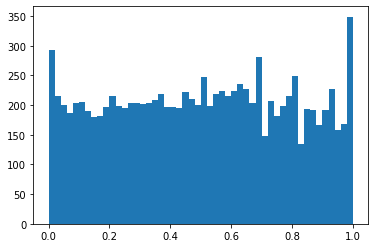

In [153]:
PIT  = calculate_PIT(predictions,y_test)
plt.hist(PIT, bins = 50)

In [158]:
CRPS = calculate_CRPS(predictions,y_test)

(array([5.559e+03, 1.946e+03, 8.960e+02, 4.790e+02, 3.360e+02, 2.340e+02,
        1.770e+02, 1.520e+02, 1.200e+02, 8.800e+01, 7.600e+01, 5.300e+01,
        3.100e+01, 2.600e+01, 1.700e+01, 1.800e+01, 1.500e+01, 1.500e+01,
        6.000e+00, 1.300e+01, 1.100e+01, 7.000e+00, 6.000e+00, 9.000e+00,
        3.000e+00, 4.000e+00, 9.000e+00, 9.000e+00, 3.000e+00, 5.000e+00,
        6.000e+00, 7.000e+00, 5.000e+00, 5.000e+00, 5.000e+00, 3.000e+00,
        4.000e+00, 0.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 1.000e+00]),
 array([2.31300000e-03, 6.93250500e-02, 1.36337100e-01, 2.03349150e-01,
        2.70361200e-01, 3.37373250e-01, 4.04385300e-01, 4.71397350e-01,
        5.38409400e-01, 6.05421450e-01, 6.72433500e-01, 7.39445550e-01,
        8.06457600e-01, 8.73469650e-01, 9.40481700e-01, 1.00749375e+00,
        1.07450580e+00, 1.14151785e+00, 1.20852990e+00, 1.27554195e+00,
        1.342554

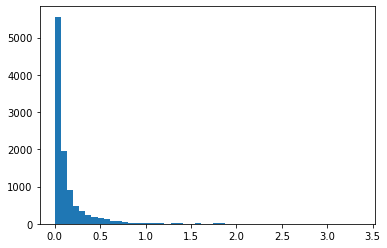

In [161]:
plt.hist(CRPS,bins = 50)